In [1]:
import numpy.typing as npt
import LS_Functions as lsf
import aicspylibczi as czi
import numpy as np
import math
import sys

from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from skimage.util import img_as_float
from fast_histogram import histogram2d, histogram1d
from scipy.optimize import fmin_cobyla
from skimage.transform import downscale_local_mean
from skimage.util import img_as_float
from tqdm import tqdm
def make_non_singular(matrix, epsilon=1e-9):
    """
    Checks if a matrix is singular and adds a small number to its diagonal
    until it becomes non-singular.

    Args:
        matrix (np.ndarray): The input square matrix.
        epsilon (float): The small number to add to the diagonal.

    Returns:
        np.ndarray: A non-singular version of the input matrix.
    """
    # Create a copy to avoid modifying the original matrix in-place
    modified_matrix = matrix.copy()

    # Use a small tolerance for floating-point comparisons
    tolerance = 1e-12

    # Check the determinant in a loop in case multiple additions are needed
    while np.abs(np.linalg.det(modified_matrix)) < tolerance:
        print("Matrix is singular. Adding epsilon to the diagonal.")
        modified_matrix += epsilon * np.eye(modified_matrix.shape[0])

    return modified_matrix

def shannon_entropy(a: npt.NDArray) -> float:
    """
    This runs very often, so we should do our best to make this fast.
    See 'profiling/shannon-entropy.ipynb' for why this was chosen
    """
    # seems like flattened arrays are faster, but .flatten() produces a copy so we
    # stick with .ravel()
    a = a.ravel()
    a /= a.sum()
    a = a[np.nonzero(a != 0)]
    a *= np.log2(a)
    return -a.sum().item()
def mutual_information(x: npt.NDArray, y: npt.NDArray, *, bins=100) -> float:
    try:
        x = x.ravel()
        y = y.ravel()

        x_range = (x.min(), x.max())
        y_range = (y.min(), y.max())

        # TODO: even though fast-histogram is pretty dang fast, consider boost-histogram?
        #  measure perf diff
        c_xy = histogram2d(x, y, bins, (x_range, y_range))
        c_x = histogram1d(x, bins, x_range)
        c_y = histogram1d(y, bins, y_range)

        h_xy = shannon_entropy(c_xy)
        h_x = shannon_entropy(c_x)
        h_y = shannon_entropy(c_y)
    except:
        print('something wrong!')
        h_x = 100
        h_y = 100
        h_xy = 100
    return h_x + h_y - h_xy
def mutual_information_range(x: npt.NDArray, y: npt.NDArray, *, bins=256) -> float:
    try:
        x = x.ravel()
        y = y.ravel()
        Range = np.min([x.nanmin(), y.nanmin()]), np.max([x.nanmax(), y.nanmax()])
        # TODO: even though fast-histogram is pretty dang fast, consider boost-histogram?
        #  measure perf diff
        c_xy = histogram2d(x, y, bins, (Range, Range))
        c_x = histogram1d(x, bins, Range)
        c_y = histogram1d(y, bins, Range)

        h_xy = shannon_entropy(c_xy)
        h_x = shannon_entropy(c_x)
        h_y = shannon_entropy(c_y)
    except:
        print('something wrong!')
        h_x = 100
        h_y = 100
        h_xy = 100
    return h_x + h_y - h_xy
def regional_mi(x: npt.NDArray, y: npt.NDArray) -> float:
    """
    FIXME not optimized, but doesn't give us better results than regular mi, so not
     worth it at the moment
    """
    x = np.copy(x)
    y = np.copy(y)

    x /= x.max()
    y /= y.max()

    r = 1

    stack = []
    for ri in range(2 * r):
        for rj in range(2 * r):
            stack.append(x[ri : -2 * r + ri, rj : -2 * r + rj])
    for ri in range(2 * r):
        for rj in range(2 * r):
            stack.append(y[ri : -2 * r + ri, rj : -2 * r + rj])
    stack = np.stack(stack)
    stack = np.reshape(stack, (stack.shape[0], -1))

    dim, n_points = stack.shape[:2]
    hdim = dim // 2

    mean = np.mean(stack, axis=1, keepdims=True)
    stack -= mean
    cov = stack @ stack.T / n_points
    h_xy = math.log(np.linalg.det(cov))
    h_x = math.log(np.linalg.det(cov[:hdim, :hdim]))
    h_y = math.log(np.linalg.det(cov[hdim:, hdim:]))
    return h_x + h_y - h_xy
def minimize_mi(x: npt.NDArray, y: npt.NDArray, *, init_alpha=0.0) -> float:
    def func(alpha: npt.NDArray):
        return mutual_information(x, y - alpha * x)

    result: npt.NDArray = fmin_cobyla(
        func=func,
        x0=np.array([init_alpha]),
        cons=[lambda a: a],
        rhobeg=1e-2,
        rhoend=1e-8,
    )
    return result.item()
def compute_unmixing_matrix(
    image: npt.NDArray,
    *,
    max_iters=1000,
    step_mult=0.1,
    verbose=False,
    return_iters=False,
) -> npt.NDArray:
    assert image.ndim == 3  # CYX
    n_channels = image.shape[0]

    image = img_as_float(image)
    image_orig = image.copy()

    mat_cumul = np.eye(n_channels, dtype=float)
    mat_last = np.eye(n_channels, dtype=float)

    mats = []
    for _ in tqdm(
        range(max_iters),
        disable=not verbose,
        desc="Unmixing iterations",
        total=0,
        file=sys.stdout,
    ):
        mat = np.eye(n_channels, dtype=float)

        for row in range(n_channels):
            for col in range(n_channels):
                if row == col:
                    continue

                coef = minimize_mi(
                    image[col], image[row], init_alpha=mat_last[row, col]
                )
                mat[row, col] = -step_mult * coef

        # check this early on
        if np.allclose(mat, mat_last):
            break
        mat_last = mat.copy()

        # update matrix
        assert mat_cumul.shape == (n_channels, n_channels)
        mat_cumul = mat @ mat_cumul

        # constrain coefficients to 1.0 along the diagonal, and negative for
        # off-diagonal entries
        for row in range(n_channels):
            for col in range(n_channels):
                if row == col:
                    mat_cumul[row, col] = 1.0
                else:
                    if mat_cumul[row, col] > 0.0:
                        mat_cumul[row, col] = 0.0
        mats.append(mat_cumul.copy())

        # update the next iteration of image
        assert mat_cumul.shape == (n_channels, n_channels)
        assert image.ndim == 3
        # several times faster than np.einsum
        image = np.tensordot(mat_cumul, image_orig, axes=1)

    if return_iters:
        return np.stack(mats)
    else:
        return mats[-1]
def generate_equally_spaced_n_dim_points(N_comp, modulation=0.95):
    """
    Generates N_comp N_comp-dimensional points equally spaced in phase.

    Args:
        N_comp (int): The number of points and the dimensionality.
        modulation (float): The modulation value, which must be < 1.

    Returns:
        np.ndarray: An array of shape (N_comp, N_comp) containing the points.
    """
    if not 0 < modulation < 1:
        raise ValueError("Modulation must be between 0 and 1.")

    # Create an array to hold all the points
    points = np.zeros((N_comp, N_comp))

    # Calculate the phase for each point
    phases = (2 * np.pi * np.arange(N_comp)) / N_comp

    # A phase offset for each dimension to ensure equal spacing in the N-dim space
    # This is a key part of the corrected approach.
    dim_phase_offset = (2 * np.pi * np.arange(N_comp)) / N_comp

    for i in range(N_comp):
        for j in range(N_comp):
            # Calculate each coordinate for point 'i'
            # The coordinate is determined by its phase and a unique dimensional offset
            points[i, j] = modulation * np.cos(phases[i] + dim_phase_offset[j])
            
    return points
def compute_unmixing_matrix_phasor(img_spectral,N_comp):
    coord = np.zeros_like(img_spectral)[:N_comp]
    for i in range(N_comp):
        if i % 2 == 0: 
            n_harmonic = (i // 2) + 1
            g, s, ph, m = lsf.PhasorTransform_Slow_3D(img_spectral, axis=0, n_harmonic=n_harmonic)
            coord[i] = g
        else: 
            coord[i] = s
def unmix(coord,img_int,coord_pure,Shape):
    f = np.matmul(np.linalg.inv(coord_pure),coord.reshape(Shape[0],-1)).reshape(Shape)
    unmixed = f*img_int
    unmixed[np.isnan(unmixed)] = 0
    unmixed[np.isinf(unmixed)] = 0
    return np.abs(unmixed)
def minimize_mi_phasor(coord,img_int,coord_guess,Shape,i,j):
    init_alpha = coord_guess[i,j]
    def func(alpha: npt.NDArray):
        coord_guess[i,j] = alpha
        unmixed = unmix(coord,img_int,coord_guess,Shape)
        mi12 = mutual_information(unmixed[i], unmixed[j])
        #mi_int = mutual_information(unmixed.sum(0), img_int[0])
        #return mi12 + mi_int
        return mi12

    result: npt.NDArray = fmin_cobyla(
        func=func,
        x0=np.array([init_alpha]),
        cons=[lambda a: a],
        rhobeg=1e-2,
        rhoend=1e-8,
    )
    return result.item()

import numpy as np
import numpy.typing as npt
from scipy.optimize import fmin_cobyla

# Note: The functions unmix() and mutual_information() are assumed to be defined elsewhere.
# These are the core functions of your unmixing algorithm.

def minimize_mi_phasor_1shot(coord, img_int, coord_guess, Shape, i_comp,j_comp):
    """
    Minimizes the mutual information between a single component and all other
    components using the fmin_cobyla optimizer.

    This function is a corrected version of the user-provided code.

    Args:
        coord (np.ndarray): The phasor coordinates.
        img_int (np.ndarray): The intensity image.
        coord_guess (np.ndarray): The initial guess for the unmixing matrix.
        Shape (tuple): The shape of the original image (height, width).
        i_comp (int): The index of the component to be optimized.

    Returns:
        np.ndarray: The optimized unmixing matrix.
    """
    N_comp = len(coord_guess)

    def func(x: npt.NDArray):
        # fmin_cobyla passes a flattened array of parameters.
        # We must reshape it back into the unmixing matrix.
        coord_guess_matrix = x.reshape(N_comp, N_comp)
        
        # Perform the unmixing to get the component images.
        unmixed = unmix(coord, img_int, coord_guess_matrix, Shape)
        
        # The objective is to minimize the mutual information between the chosen
        # component and all other components. We use the average for a scalar objective.
        mi_int = mutual_information(unmixed.sum(0), img_int[0])
        mi12 = mutual_information(unmixed[i_comp], unmixed[j_comp])
        return mi12

    # --- Constraints ---
    # We want to constrain each element of the unmixing matrix to be between -1 and 1.
    # This requires two lambda functions for the upper and lower bounds.
    # The lambda function syntax `lambda a: ...` correctly handles the single
    # parameter `a` passed by fmin_cobyla, which is the flattened parameter array.
    cons = [
        lambda a: a + 1,  # Lower bound constraint: a >= -1
        lambda a: 1 - a   # Upper bound constraint: a <= 1
    ]

    # --- Optimization ---
    result: npt.NDArray = fmin_cobyla(
        func=func,
        x0=coord_guess.flatten(),  # The initial guess must be a 1D array.
        cons=cons,
    )
    
    # fmin_cobyla returns a flattened array. We reshape it back into the
    # unmixing matrix for the return value.
    return result.reshape(N_comp, N_comp)

def minimize_mi_phasor_1shot_v2(img_spectral, coord, coord_guess, i_comp,j_comp):
    N_comp = len(coord_guess)

    def func(x: npt.NDArray):
        # fmin_cobyla passes a flattened array of parameters.
        # We must reshape it back into the unmixing matrix.
        coord_guess_matrix = make_non_singular(x.reshape(N_comp, N_comp))

        # Perform the unmixing to get the component images.
        unmixed = GS2IMG(coord,coord_guess_matrix,img_spectral)
        unmixed[unmixed < 0] = 0
        # The objective is to minimize the mutual information between the chosen
        # component and all other components. We use the average for a scalar objective.
        mi12 = mutual_information(unmixed[i_comp], unmixed[j_comp])
        return mi12

    # --- Constraints ---
    # We want to constrain each element of the unmixing matrix to be between -1 and 1.
    # This requires two lambda functions for the upper and lower bounds.
    # The lambda function syntax `lambda a: ...` correctly handles the single
    # parameter `a` passed by fmin_cobyla, which is the flattened parameter array.
    cons = [
        lambda a: a + 1,  # Lower bound constraint: a >= -1
        lambda a: 1 - a   # Upper bound constraint: a <= 1
    ]

    # --- Optimization ---
    result: npt.NDArray = fmin_cobyla(
        func=func,
        x0=coord_guess.flatten(),  # The initial guess must be a 1D array.
        cons=cons,
    )
    
    # fmin_cobyla returns a flattened array. We reshape it back into the
    # unmixing matrix for the return value.
    return result.reshape(N_comp, N_comp)

from IPython.display import clear_output

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show()
    
def live_phasor_plot(data_dict, figsize=(10,5), title=''):
    colors = 'rbgkc'
    clear_output(wait=True)
    fig,ax = plt.subplots(1,2,figsize=figsize)
    for label,data in data_dict.items():
        if label == 'g':
            g = data.copy()
        elif label == 's':
            s = data.copy()
        else:
            ax[0].plot(data, label=label)
    for i in range(g.shape[1]):
        ax[1].plot(g[:,i],s[:,i], '-o',color = colors[i],markeredgecolor = 'k',label=i)
    ax[1].set_xlim((-1,1))
    ax[1].set_ylim((-1,1))
    ax[0].set_title(title)
    ax[0].grid(True)
    ax[0].set_xlabel('epoch')
    plt.show()
    
    
    

LS_Functions: Couldnt import cupy
LS_Functions: Couldnt import cupyx


[[ 0.66893031 -0.24558959]
 [ 0.67613828  0.69906734]]


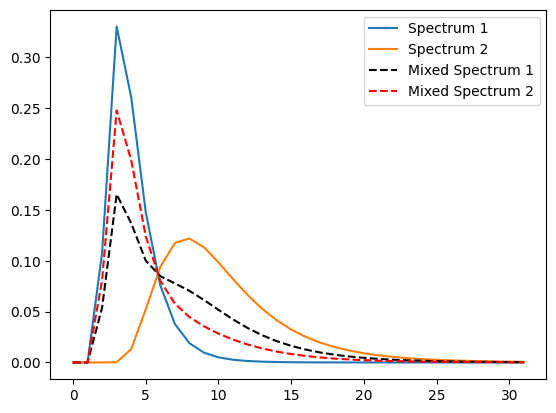

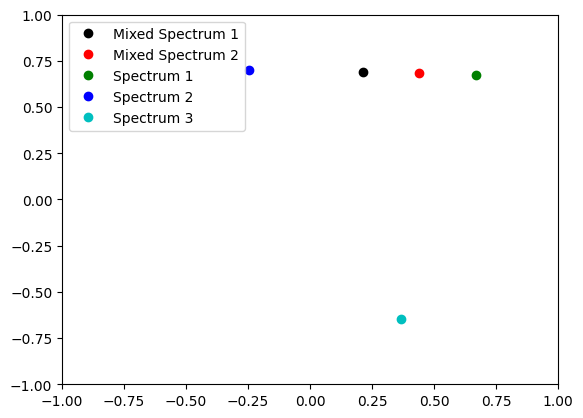

In [26]:
from scipy import stats

def gaussian(x, mean, stddev):
    coeff = 1 / (stddev * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((x - mean) / stddev) ** 2
    return coeff * np.exp(exponent)
def lognorm_pdf(x, s, loc, scale):
    return stats.lognorm.pdf(x, s, loc, scale)

mu1 = 1
mu2 = 2
mu3 = 4
stdev = .5

x = np.arange(32)
spectra1 = lognorm_pdf(x, s=stdev, loc=mu1, scale=np.exp(mu1))
spectra2 = lognorm_pdf(x, s=stdev, loc=mu2, scale=np.exp(mu2))
spectra3 = lognorm_pdf(x, s=stdev, loc=mu3, scale=np.exp(mu3))
spectra_mix1 = spectra1*0.5 + spectra2*0.5
spectra_mix2 = spectra1*0.75 + spectra2*0.25
fig, ax = plt.subplots(1,1)
ax.plot(x, spectra1, label='Spectrum 1')
ax.plot(x, spectra2, label='Spectrum 2')
ax.plot(x, spectra_mix1, '--k', label='Mixed Spectrum 1')
ax.plot(x, spectra_mix2, '--r', label='Mixed Spectrum 2')
ax.legend()

gm1,sm1,phm1,mm1 = lsf.PhasorTransform_Slow_2D(spectra_mix1[:,None], axis=0, n_harmonic=1)
gm2,sm2,phm2,mm2 = lsf.PhasorTransform_Slow_2D(spectra_mix2[:,None], axis=0, n_harmonic=1)

g1,s1,ph1,m1 = lsf.PhasorTransform_Slow_2D(spectra1[:,None], axis=0, n_harmonic=1)
g2,s2,ph2,m2 = lsf.PhasorTransform_Slow_2D(spectra2[:,None], axis=0, n_harmonic=1)
g3,s3,ph3,m3 = lsf.PhasorTransform_Slow_2D(spectra3[:,None], axis=0, n_harmonic=1)
fig, ax = plt.subplots(1,1)
ax.plot(gm1, sm1, 'ok', label='Mixed Spectrum 1')
ax.plot(gm2, sm2, 'or', label='Mixed Spectrum 2')
ax.plot(g1, s1, 'og', label='Spectrum 1')
ax.plot(g2, s2, 'ob', label='Spectrum 2')
ax.plot(g3, s3, 'oc', label='Spectrum 3')
ax.legend()
ax.set_xlim((-1,1))
ax.set_ylim((-1,1))

dist = 0
coord_pure = np.asarray([[g1, s1-dist], [g2, s2+dist]])[:,:,0].T
N_comp = 2

print(coord_pure)
f_m1 = np.matmul(np.linalg.inv(coord_pure),np.asarray([gm1,sm1])[:,0])
f_m2 = np.matmul(np.linalg.inv(coord_pure),np.asarray([gm2,sm2])[:,0])


Generated spectral image of shape: (32, 256, 256)


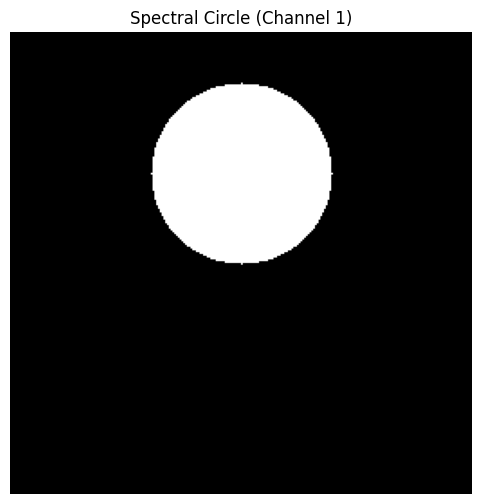

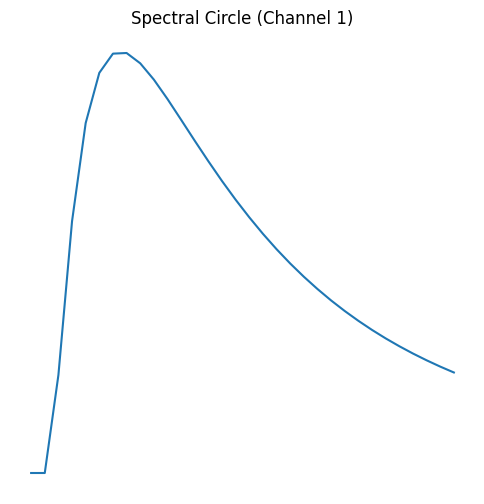

In [58]:
import numpy as np

def generate_spectral_circle(channels, height, width, radius, mu, sigma, center_x, center_y):
    """
    Generates a single circle with a Gaussian-shaped spectral profile.

    Args:
        channels (int): The number of spectral channels (e.g., 32).
        height (int): The height of the output image in pixels.
        width (int): The width of the output image in pixels.
        radius (int): The radius of the circle in pixels.
        mu (int): The mean of the Gaussian profile across the channels.
        sigma (float): The standard deviation of the Gaussian profile.
        center_x (int): The x-coordinate of the circle's center.
        center_y (int): The y-coordinate of the circle's center.

    Returns:
        np.ndarray: A 3D NumPy array of shape (height, width, channels)
                    representing the spectral image.
    """
    # Create an empty 3D array for the spectral image
    spectral_image = np.zeros((height, width, channels), dtype=np.float32)

    # Create a grid of x and y coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Calculate the distance of each pixel from the circle's center
    distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    # Create a boolean mask for all pixels inside the circle
    circle_mask = distance_from_center <= radius

    # Generate the Gaussian spectral profile across the channels
    channel_indices = np.arange(channels)
    profile = lognorm_pdf(channel_indices, s=1, loc=mu, scale=sigma)
    profile = profile / np.sum(profile)  # Normalize the profile
    # Apply the spectral profile to all pixels within the circle
    # We use NumPy's broadcasting to efficiently apply the profile
    # to every pixel that satisfies the circle_mask.
    spectral_image[circle_mask, :] = profile

    return spectral_image.transpose((2, 0, 1))

# --- Example Usage ---

# Define the parameters for the function call
channels = 32
height = 256
width = 256
radius = 50
mu1 = mu1
stdev = stdev # Example standard deviation
center_x = 128
center_y = 128 - 50

# Generate the spectral circle image
img1 = generate_spectral_circle(
    channels=channels,
    height=height,
    width=width,
    radius=radius,
    mu=mu1,
    sigma=stdev,
    center_x=center_x,
    center_y=center_y
)

print(f"Generated spectral image of shape: {img1.shape}")

# Optional: Visualize a single channel of the generated image
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(np.sum(img1, axis=0), cmap='gray')  # Display the central channel
plt.title(f'Spectral Circle (Channel {mu1})')
plt.axis('off')
plt.show()
plt.figure(figsize=(6, 6))
plt.plot(np.sum(img1, axis=(1,2)))  # Display the central channel
plt.title(f'Spectral Circle (Channel {mu1})')
plt.axis('off')
plt.show()

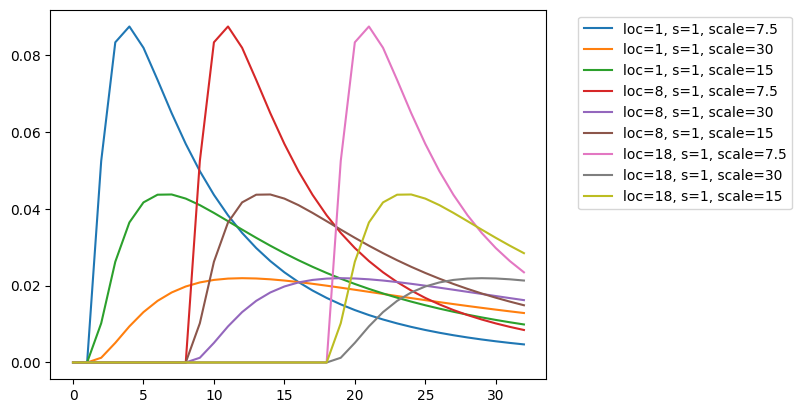

In [57]:
fig,ax = plt.subplots(1,1)
x = np.arange(33)
for loc in [mu1, mu2, mu3]:
    for s in [1]:
        for scale in [.5*stdev, 2*stdev, stdev]:
            spectra = lognorm_pdf(x, s=s, loc=loc, scale=scale)
            ax.plot(spectra, label=f'loc={loc}, s={s}, scale={scale}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
channel_indices = np.arange(33)
profile = lognorm_pdf(channel_indices, s=stdev, loc=mu1, scale=height)

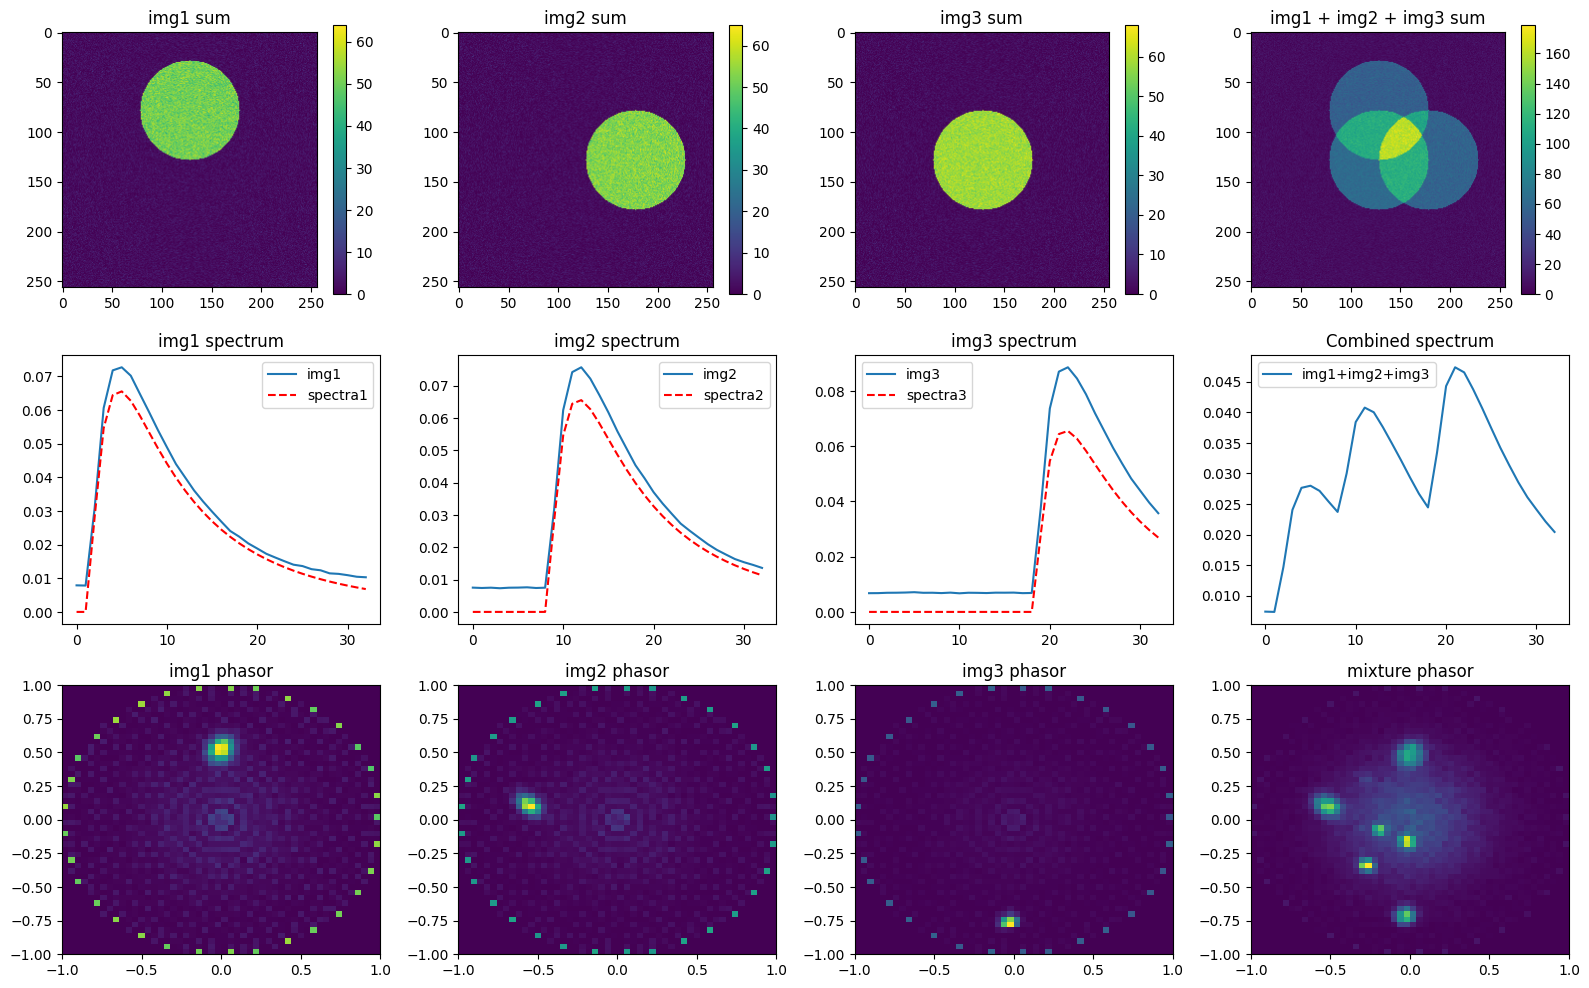

In [61]:
mu1 = 1
mu2 = 8
mu3 = 18
stdev = 10

x = np.arange(33)
spectra1 = lognorm_pdf(x, s=1, loc=mu1, scale=stdev)
spectra2 = lognorm_pdf(x, s=1, loc=mu2, scale=stdev)
spectra3 = lognorm_pdf(x, s=1, loc=mu3, scale=stdev)
g1_spectra,s1_spectra,ph1_spectra,m1 = lsf.PhasorTransform_Slow_2D(spectra1[:,None], axis=0, n_harmonic=1)
g2_spectra,s2_spectra,ph2_spectra,m2 = lsf.PhasorTransform_Slow_2D(spectra2[:,None], axis=0, n_harmonic=1)
g3_spectra,s3_spectra,ph3_spectra,m3 = lsf.PhasorTransform_Slow_2D(spectra3[:,None], axis=0, n_harmonic=1)

g1_2_spectra,s1_2_spectra,ph1_2_spectra,m1_2 = lsf.PhasorTransform_Slow_2D(spectra1[:,None], axis=0, n_harmonic=2)
g2_2_spectra,s2_2_spectra,ph2_2_spectra,m2_2 = lsf.PhasorTransform_Slow_2D(spectra2[:,None], axis=0, n_harmonic=2)
g3_2_spectra,s3_2_spectra,ph3_2_spectra,m3_2 = lsf.PhasorTransform_Slow_2D(spectra3[:,None], axis=0, n_harmonic=2)

spectra_mix1 = spectra1*0.5 + spectra2*0.5
spectra_mix2 = spectra1*0.75 + spectra2*0.25
spectra_mix3 = spectra1*0.25 + spectra2*0.75
gm1,sm1,phm1,mm1 = lsf.PhasorTransform_Slow_2D(spectra_mix1[:,None], axis=0, n_harmonic=1)
gm2,sm2,phm2,mm2 = lsf.PhasorTransform_Slow_2D(spectra_mix2[:,None], axis=0, n_harmonic=1)
gm3,sm3,phm3,mm3 = lsf.PhasorTransform_Slow_2D(spectra_mix3[:,None], axis=0, n_harmonic=1)

x = np.linspace(0, 1, 256)
xx, yy = np.meshgrid(x, x)
img1 = generate_spectral_circle(
    channels=33, 
    height=256, 
    width=256, 
    radius=50, 
    mu=mu1, 
    sigma=stdev, 
    center_x=128, 
    center_y=128-50
)
img2 = generate_spectral_circle(
    channels=33, 
    height=256, 
    width=256, 
    radius=50, 
    mu=mu2, 
    sigma=stdev, 
    center_x=128+50, 
    center_y=128
)
img3 = generate_spectral_circle(
    channels=33, 
    height=256, 
    width=256, 
    radius=50, 
    mu=mu3, 
    sigma=stdev, 
    center_x=128, 
    center_y=128
)

noise_std = .01
img1 = img1 + np.random.normal(0, noise_std, img1.shape)
img2 = img2 + np.random.normal(0, noise_std, img2.shape)
img3 = img3 + np.random.normal(0, noise_std, img3.shape)
img1[img1 < 0] = 0
img2[img2 < 0] = 0
img3[img3 < 0] = 0
img1 = (img1 * 64).astype(np.uint8)
img2 = (img2 * 64).astype(np.uint8)
img3 = (img3 * 64).astype(np.uint8)
g1,s1,ph1,m1 = lsf.PhasorTransform_Slow_3D(img1, axis=0, n_harmonic=1)
g2,s2,ph2,m2 = lsf.PhasorTransform_Slow_3D(img2, axis=0, n_harmonic=1)
g3,s3,ph3,m3 = lsf.PhasorTransform_Slow_3D(img3, axis=0, n_harmonic=1)

img_mix = img1 + img2 + img3
gmix,smix,phmix,mmix            = lsf.PhasorTransform_Slow_3D(img_mix, axis=0, n_harmonic=1)
gmix_2,smix_2,phmix_2,mmix_2    = lsf.PhasorTransform_Slow_3D(img_mix, axis=0, n_harmonic=2)
coord = np.concatenate([gmix.flatten()[:,None],smix.flatten()[:,None]], axis=1)

fig, ax = plt.subplots(3, 4, figsize=(16, 10))

# Show summed images for each component and their combinations
ax1 = ax[0, 0].imshow(img1.sum(0))
plt.colorbar(ax1, ax=ax[0, 0])
ax[0, 0].set_title('img1 sum')

ax2 = ax[0, 1].imshow(img2.sum(0))
plt.colorbar(ax2, ax=ax[0, 1])
ax[0, 1].set_title('img2 sum')

ax3 = ax[0, 2].imshow(img3.sum(0))
plt.colorbar(ax3, ax=ax[0, 2])
ax[0, 2].set_title('img3 sum')

ax4 = ax[0, 3].imshow(img1.sum(0) + img2.sum(0) + img3.sum(0))
plt.colorbar(ax4, ax=ax[0, 3])
ax[0, 3].set_title('img1 + img2 + img3 sum')

# Plot normalized spectra for each image and their sum
ax[1, 0].plot(img1.sum((1, 2)) / img1.sum(), label='img1')
ax[1, 0].plot(spectra1, '--r', label='spectra1')
ax[1, 0].set_title('img1 spectrum')
ax[1, 0].legend()

ax[1, 1].plot(img2.sum((1, 2)) / img2.sum(), label='img2')
ax[1, 1].plot(spectra2, '--r', label='spectra2')
ax[1, 1].set_title('img2 spectrum')
ax[1, 1].legend()

ax[1, 2].plot(img3.sum((1, 2)) / img3.sum(), label='img3')
ax[1, 2].plot(spectra3, '--r', label='spectra3')
ax[1, 2].set_title('img3 spectrum')
ax[1, 2].legend()

ax[1, 3].plot((img1 + img2 + img3).sum((1, 2)) / (img1 + img2 + img3).sum(), label='img1+img2+img3')
ax[1, 3].set_title('Combined spectrum')
ax[1, 3].legend()

# 2D histograms of phasor coordinates for each image and the mixture
hist_bins = 50
ax[2, 0].hist2d(g1.flatten(), s1.flatten(), bins=hist_bins, range=[(-1, 1), (-1, 1)])
ax[2, 0].set_title('img1 phasor')

ax[2, 1].hist2d(g2.flatten(), s2.flatten(), bins=hist_bins, range=[(-1, 1), (-1, 1)])
ax[2, 1].set_title('img2 phasor')

g3_, s3_, _, _ = lsf.PhasorTransform_Slow_3D(img3, axis=0, n_harmonic=1)
ax[2, 2].hist2d(g3_.flatten(), s3_.flatten(), bins=hist_bins, range=[(-1, 1), (-1, 1)])
ax[2, 2].set_title('img3 phasor')


ax[2, 3].hist2d(gmix.flatten(), smix.flatten(), bins=hist_bins, range=[(-1, 1), (-1, 1)])
ax[2, 3].set_title('mixture phasor')

plt.tight_layout()
plt.show()


(3, 3)


array([ 1.74595846,  0.30051555, -0.41936038, ...,  1.40586678,
       -0.03931766, -0.26152739])

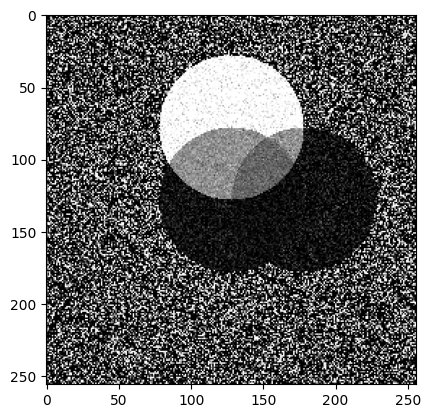

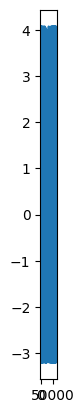

In [62]:
coord_pure = np.asarray([[g1_spectra[0], s1_spectra[0], g1_2_spectra[0]], 
                         [g2_spectra[0], s2_spectra[0], g2_2_spectra[0]], 
                         [g3_spectra[0], s3_spectra[0], g3_2_spectra[0]]])
print(coord_pure.shape)
inv_coord_pure = np.linalg.inv(coord_pure)
coord = np.concatenate([gmix.flatten()[:,None],smix.flatten()[:,None],gmix_2.flatten()[:,None]], axis=1)

fmix = np.matmul(coord, inv_coord_pure).T
fmix[np.isnan(fmix)] = 0
fmix[np.isinf(fmix)] = 0

plt.imshow(fmix[0].reshape(256,256), cmap='gray',vmin = 0,vmax = 1)

fig, ax = plt.subplots(1,1)
ax.plot(fmix[0].flatten(), label='g1')
ax.set_aspect(200000)

fmix[0].flatten()

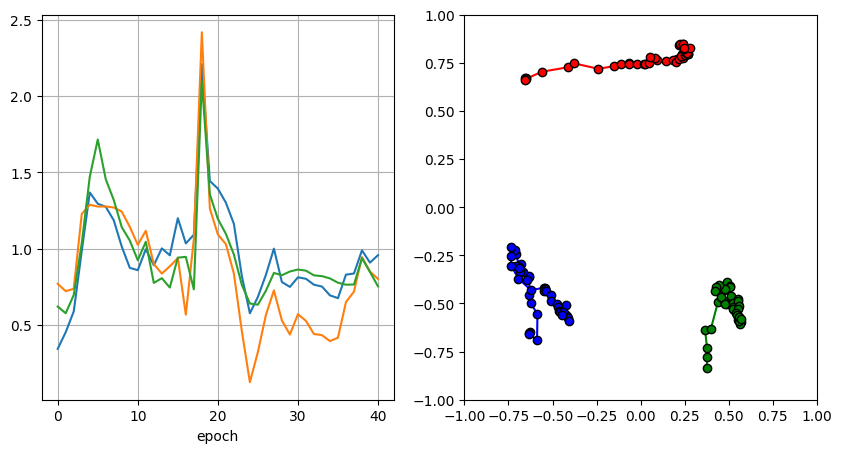

 27%|██▋       | 41/150 [00:48<02:07,  1.17s/it]


KeyboardInterrupt: 

In [208]:
n_iterations = 150
N_comp = 3
step_mult = .05

img_spectral = (img1+img2+img3).astype(np.float32)
coord = list()
_,X,Y = img_spectral.shape
C = N_comp
img_int = np.repeat(img_spectral.sum(0)[None,],N_comp,axis=0)
for i in range(N_comp):
    if i % 2 == 0: 
        n_harmonic = (i // 2) + 1
        g, s, ph, m = lsf.PhasorTransform_Slow_3D(img_spectral, axis=0, n_harmonic=n_harmonic)
        coord.append(g.flatten())
    else: 
        coord.append(s.flatten())

coord = np.asarray(coord)
coord_guess = generate_equally_spaced_n_dim_points(N_comp, modulation=0.7)
#coord_guess = np.random.uniform(low=-.7, high=.7, size=(N_comp, N_comp))
coord_guess = coord_pure.copy()

coord_first = coord_guess.copy()
coord_all = list()
data = {}
mi_all = np.zeros((n_iterations, N_comp, N_comp))
coord_all = np.zeros((n_iterations, N_comp, N_comp))
for _ in tqdm(range(n_iterations)):
    for row in range(N_comp):
        for col in range(row+1,N_comp):
            if row == col:
                continue
            coef = minimize_mi_phasor_1shot(coord,img_int,coord_guess,(C,X,Y),row,col)
            coord_guess = coord_guess + (coef - coord_guess)*step_mult
    coord_last = coord_guess.copy()
    coord_all[_] = coord_last
    
    for row in range(N_comp):
        for col in range(row+1,N_comp):
            if row == col:
                continue
            unmixed = unmix(coord, img_int, coord_guess, (C,X,Y))
            mi_int = mutual_information(unmixed.sum(0), img_int[0])
            mi12 = mutual_information(unmixed[row], unmixed[col])
            mi_all[_,row,col] = mi12 
            data['a'+str(row)+'_'+str(col)] = mi_all[:_+1,row,col]
    data['g'] = coord_all[:_+1,:,0]
    data['s'] = coord_all[:_+1,:,1]
    live_phasor_plot(data)


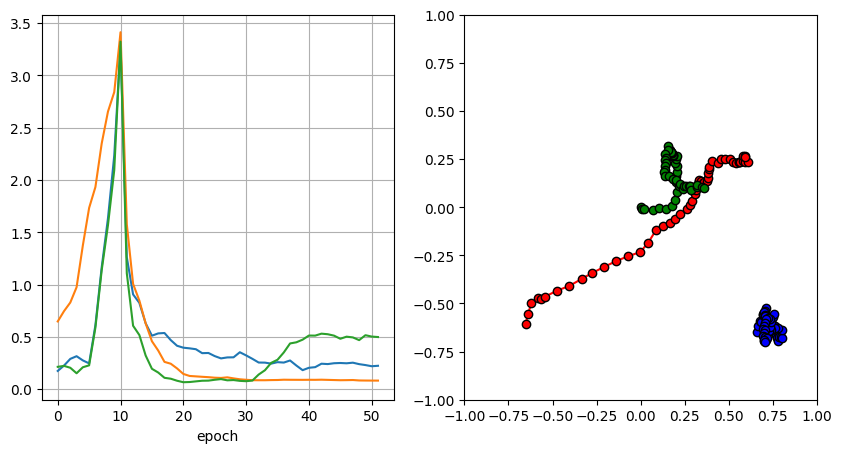

 52%|█████▏    | 52/100 [01:02<00:57,  1.20s/it]


KeyboardInterrupt: 

In [235]:
img_spectral = (img1+img2+img3).astype(np.float32)
Spectra = np.concatenate([spectra1[:,None], spectra2[:,None], spectra3[:,None]], axis=1)

GS_pure = Get_GS_Pure(Spectra, [0,1,2])
coord = Get_GS(img_spectral,GS_pure)

n_iterations = 100
N_comp = 3
step_mult = .025

#coord_guess = generate_equally_spaced_n_dim_points(N_comp, modulation=0.7)
coord_guess = GS_pure.copy()

coord_first = coord_guess.copy()
coord_all = list()
data = {}
mi_all = np.zeros((n_iterations, N_comp, N_comp))
coord_all = np.zeros((n_iterations, N_comp, N_comp))
for _ in tqdm(range(n_iterations)):
    for row in range(N_comp):
        for col in range(row+1,N_comp):
            if row == col:
                continue
            coef = minimize_mi_phasor_1shot_v2(img_spectral, coord,coord_guess,row,col)
            coord_guess = make_non_singular(coord_guess + (coef - coord_guess)*step_mult)

    coord_last = coord_guess.copy()
    coord_all[_] = coord_last
    
    for row in range(N_comp):
        for col in range(row+1,N_comp):
            if row == col:
                continue
            unmixed = GS2IMG(coord,coord_guess,img_spectral)
            unmixed[unmixed < 0] = 0
            mi_int = mutual_information(unmixed.sum(0), img_int[0])
            mi12 = mutual_information(unmixed[row], unmixed[col])
            mi_all[_,row,col] = mi12 
            data['a'+str(row)+'_'+str(col)] = mi_all[:_+1,row,col]
    data['g'] = coord_all[:_+1,:,0]
    data['s'] = coord_all[:_+1,:,1]
    live_phasor_plot(data)


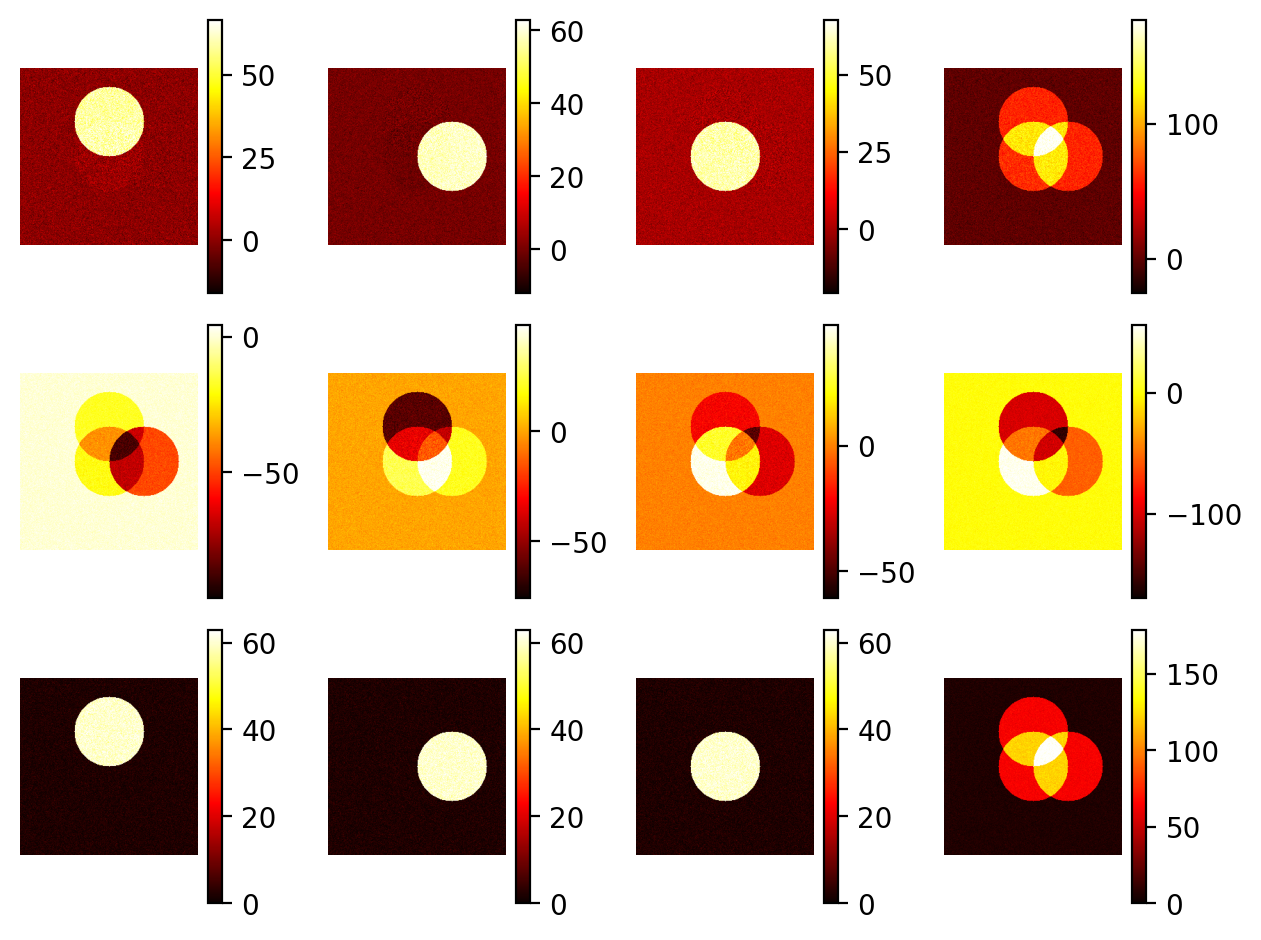

In [236]:

coord = list()
_,X,Y = img_spectral.shape
C = N_comp
img_int = np.repeat(img_spectral.sum(0)[None,],N_comp,axis=0)
for i in range(N_comp):
    if i % 2 == 0: 
        n_harmonic = (i // 2) + 1
        g, s, ph, m = lsf.PhasorTransform_Slow_3D(img_spectral, axis=0, n_harmonic=n_harmonic)
        coord.append(g.flatten())
    else: 
        coord.append(s.flatten())

coord = np.asarray(coord)

unmixed0,_ = Unmix(img_spectral, coord_first)
unmixed,_ = Unmix(img_spectral, coord_last)

fig, ax = plt.subplots(3, N_comp+1, dpi=200)
vmax = np.percentile(unmixed, 99)
vmax0 = np.percentile(unmixed0, 99)
for ch in range(N_comp):
    ax1 = ax[0, ch].imshow(unmixed0[ch], cmap='hot', vmax=np.percentile(unmixed0[ch], 99))
    ax2 =ax[1, ch].imshow(unmixed[ch], cmap='hot', vmax=np.percentile(unmixed[ch], 99))
    plt.colorbar(ax1)
    plt.colorbar(ax2)
    
ax1i = ax[0, N_comp].imshow(unmixed0.sum(0), cmap='hot', vmax=np.percentile(unmixed0.sum(0), 99))
ax2i = ax[1, N_comp].imshow(unmixed.sum(0), cmap='hot', vmax=np.percentile(unmixed.sum(0), 99))
plt.colorbar(ax1i)
plt.colorbar(ax2i)

ax3 =ax[2, 0].imshow(img1.sum(0), cmap='hot', vmax=np.percentile(img1.sum(0), 99))
ax4 =ax[2, 1].imshow(img2.sum(0), cmap='hot', vmax=np.percentile(img2.sum(0), 99))
ax5 =ax[2, 2].imshow(img3.sum(0), cmap='hot', vmax=np.percentile(img3.sum(0), 99))
ax4i =ax[2, N_comp].imshow(img_spectral.sum(0), cmap='hot', vmax=np.percentile(img_spectral.sum(0), 99))
plt.colorbar(ax3)
plt.colorbar(ax4)
plt.colorbar(ax5)
plt.colorbar(ax4i)
for axs in ax.ravel():
    axs.set_axis_off()
fig.tight_layout()


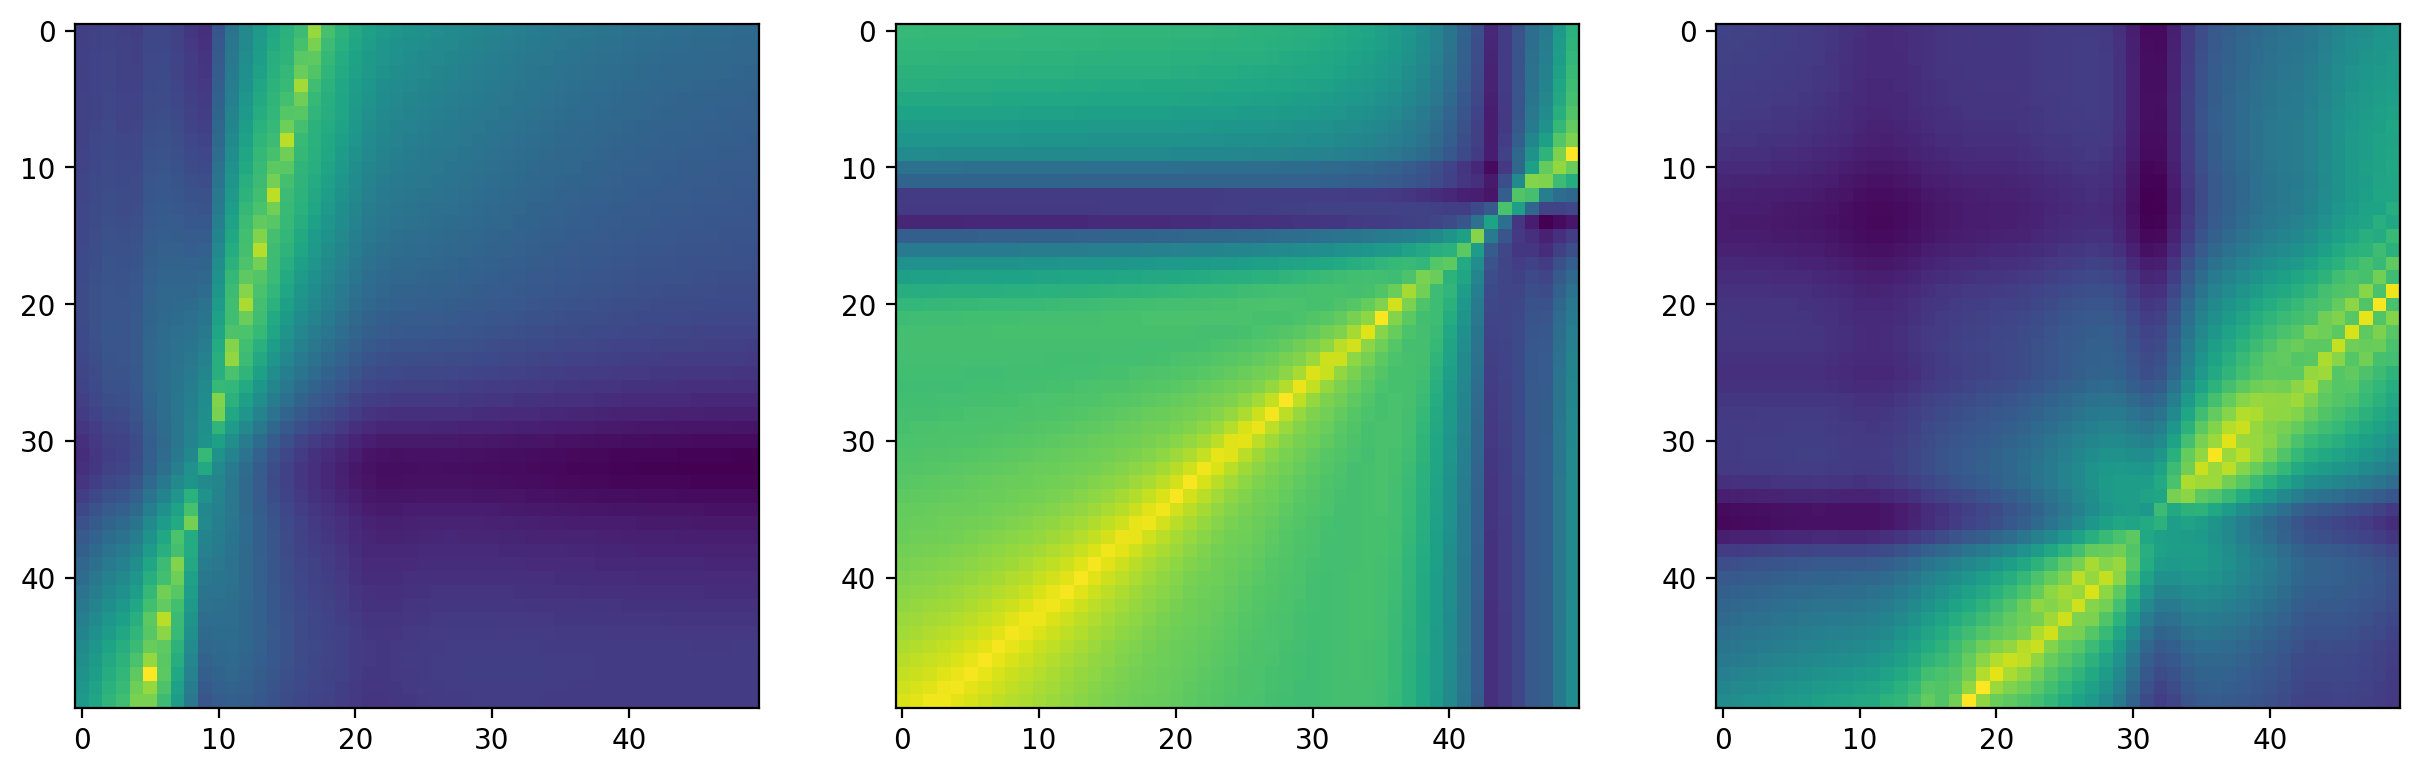

In [237]:
coord_guess = GS_pure.copy()
N_test = 50
x = np.linspace(-1,1,N_test)
gg,ss = np.meshgrid(x,x)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
mi_matrix = np.zeros((N_test, N_test))
for i_comp in range(3):
    coord_guess = np.random.uniform(low=-.7, high=.7, size=(N_comp, N_comp))
    for i in range(N_test):
        for j in range(N_test):
            coord_guess[i_comp, 0] = gg[i, j]
            coord_guess[i_comp, 1] = ss[i, j]
            unmixed = GS2IMG(coord,coord_guess,img_spectral)
            mi_matrix[i, j] = mutual_information(unmixed[row], unmixed[col])
    ax[i_comp].imshow(mi_matrix)

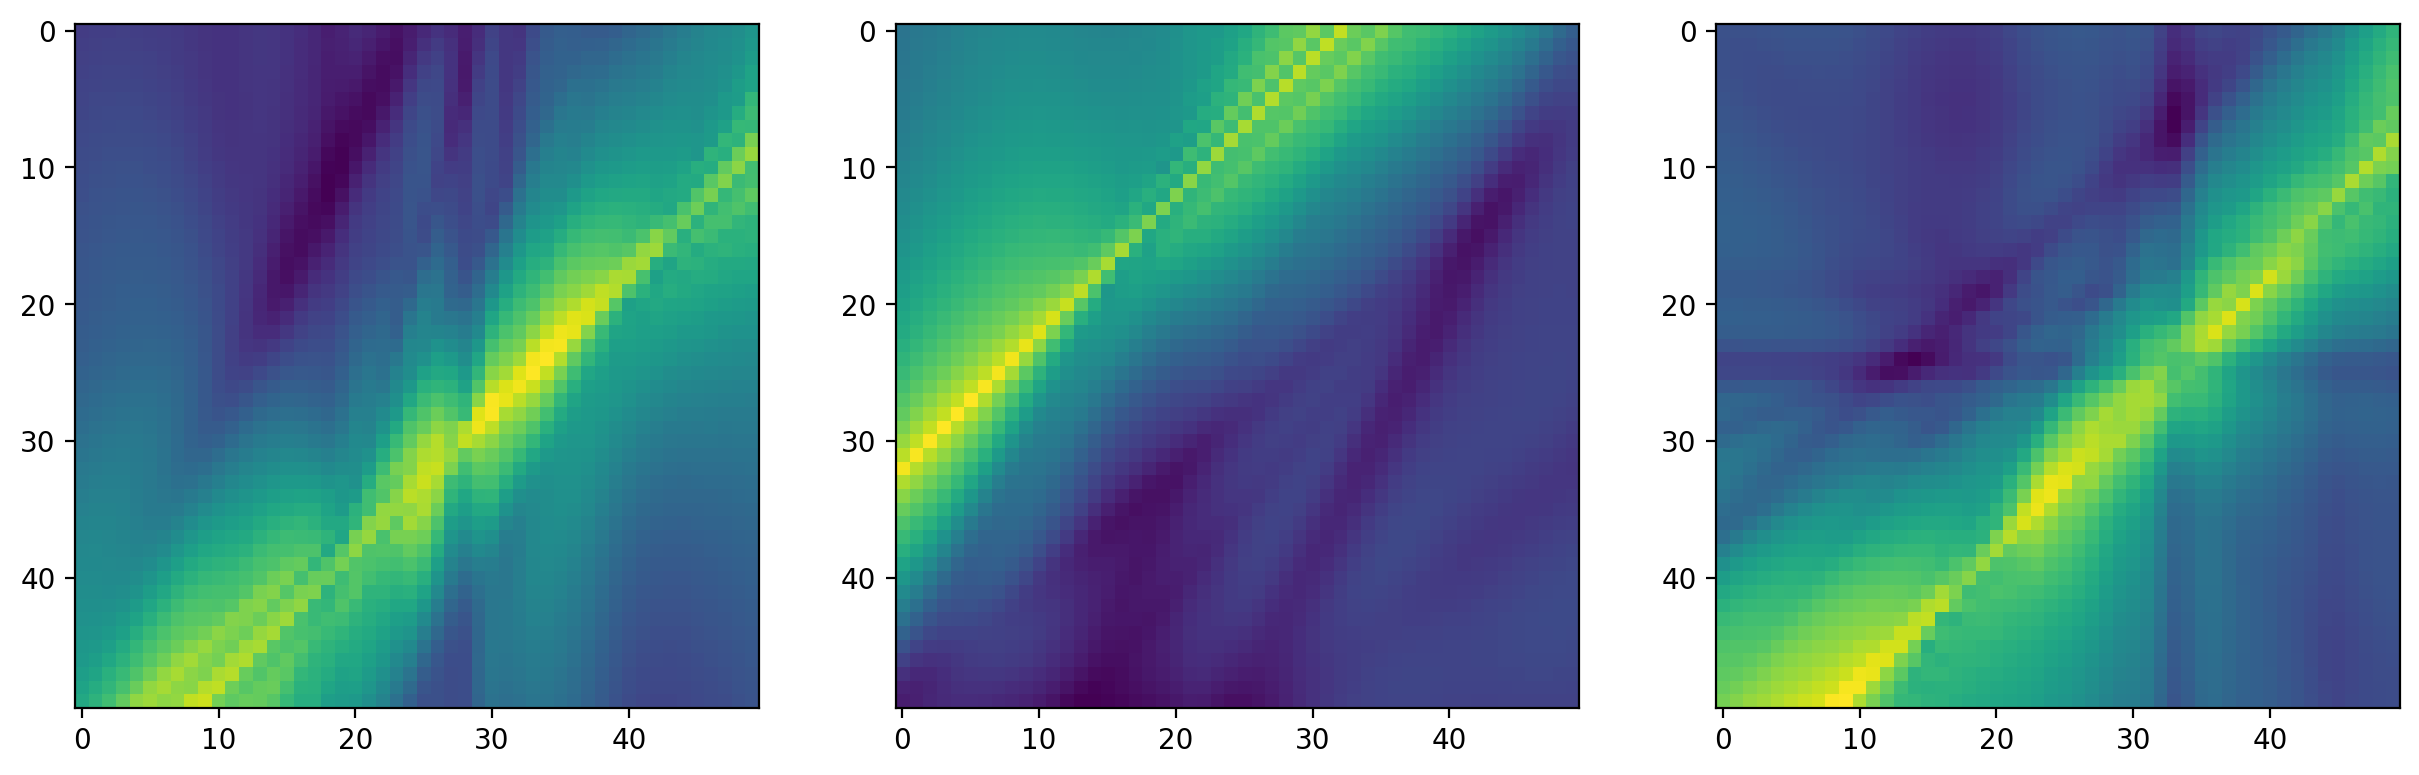

In [ ]:
coord_guess = generate_equally_spaced_n_dim_points(N_comp, modulation=0.7)
N_test = 50
x = np.linspace(-1,1,N_test)
gg,ss = np.meshgrid(x,x)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
mi_matrix = np.zeros((N_test, N_test))
for i_comp in range(3):
    for i in range(N_test):
        for j in range(N_test):
            coord_guess = generate_equally_spaced_n_dim_points(N_comp, modulation=0.7)
            coord_guess[i_comp, 0] = gg[i, j]
            coord_guess[i_comp, 1] = ss[i, j]
            unmixed = GS2IMG(coord,coord_guess,img_spectral)
            mi_matrix[i, j] = mutual_information(unmixed[row], unmixed[col])
    ax[i_comp].imshow(mi_matrix)